In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
from matplotlib import pyplot as plt
from IPython import display
import signal

In [11]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
Slightly modified by Nthend
"""

'\nMinimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)\nBSD License\nSlightly modified by Nthend\n'

In [3]:
import numpy as np

# data I/O
data = open('data/witcher_rus.txt', 'r', encoding='utf-8').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
print(chars)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

data has 4508884 characters, 141 unique.
['А', '"', 'ы', 'ъ', 'Г', 'У', 'э', '-', 'Ч', '1', 'X', 'W', 'Э', 'S', 'O', "'", '\t', 'П', 'З', 'К', 'i', 'v', 'Х', 'Ю', 'Ш', 'U', 'т', 'P', 'ч', 'V', '0', 'p', 'я', 'Z', 'c', '9', 'Ф', 'M', 'Р', 'з', 'L', '4', 'ц', ' ', 'Щ', 'h', 'o', 'н', 'р', 'Ж', 'G', 'H', ';', 't', 'Е', 'Ы', 'x', 'K', 'Н', '#', 'R', 'у', 'ё', 'щ', 'r', 'х', 'Т', '8', ':', '?', 'с', '7', 'Ь', '5', 'ж', 'A', 'б', 'd', 'Л', 'm', ',', 'в', 'Ц', 'к', 'e', 'ш', 'D', 'F', 'k', 'ь', 'w', 'E', 'z', '2', 'е', 'л', 'T', '3', 'В', 'J', 'м', 'Я', 'а', '!', 'l', '*', 'n', 'о', 'п', 'О', 'y', 'г', 'I', 'ф', 's', '6', 'B', 'Й', 'ю', 'b', 'Q', 'N', 'u', '.', '\n', 'f', 'д', 'й', 'C', 'q', 'и', '(', 'a', 'g', 'М', 'Y', 'Д', 'Б', ')', 'И', 'С']


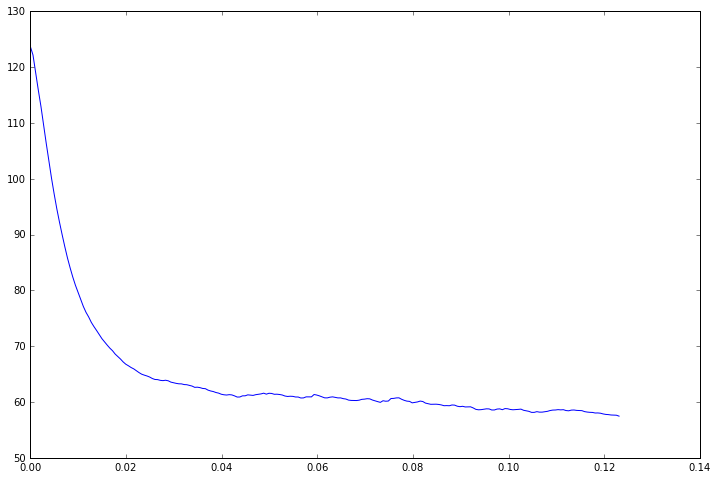

In [4]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

plot = True
passes = []
losses = []

while not done:
    if n % 100 == 0: display.clear_output(wait=True)
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0: 
        book_pass = n*seq_length/len(data)
        if plot:
            passes.append(book_pass)
            losses.append(smooth_loss)
            ax = plt.figure().add_subplot(111)
            ax.plot(passes, losses)
            plt.show()
        else:
            print('pass: %f, loss: %f' % (book_pass, smooth_loss)) # print progress
    
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

In [10]:
sample_ix = sample(hprev, inputs[0], 2000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print(txt)

лал?

- Дак - имы вми, нежалашку удедата дразсе ты томенно, язалноду трие нодорашой позпоезтась на каздае, зымаше, шими скакиев - расинкифоту. aеиз. Ондуре ртя том нам?

- Наек. Повенодики.

- Госен.

- не гевиль, натыми, е манивсининакос и тедносви реснде, рыдсякививае него с ботовитака т говеналуе дроны взи рамоменуеста, обальте свичате хрологлей Наами не слико в бержнафях, - из сбончевшушь, - а селся чильхонни бодщицна доньмика и утала семленол - полятимся мидь.

Ракреснуеская!

- Ты конялтивама, - коз изе посхрэеста, нивешь догоести, суроб, сраки - не, бужастось с мтанось. Периглють, ты оне позстису. Эй Денсо, колазаяе!

- У я рыворнесто, Йенився гризая варерэе слоску, - довафи и сотро игирано ззнаем хлет, в Sешаля крачкая накнесте болок!, - шикоД, - ты влетилесь сзал ск, скапрак кам, на ормадать пруку?

- Столовымала грого изаем раруссовала мосумат,, побыед, кокорак утоно вакаех Гарадь на слноська, еа не нем Вусть грен совуще воснино В медловес. А дага ужно - прусеренке Бривым Бог